# Make a faster version of spectrogram generation code, using notes from Monday's meeting such as 

1) Load in all video files to start

2) Save all channels simultaneously

3) badtimes based on index in mat file

4) ...

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import os
from scipy.stats import zscore


In [3]:
import scipy

In [4]:
from scipy.io import loadmat

In [5]:
spec_data = loadmat('../../../Spectrogram_mat_data/N10W1dn1_180326_rec005.mat')

In [7]:
spec_data['Spec_per_Ch']['Ch1'][0][0]['ti'][0][0]

array([[5.00000000e+03, 6.00019330e+03, 7.00038660e+03, ...,
        7.20039061e+06, 7.20139081e+06, 7.20239100e+06]])

In [31]:
    night = file.split('_')[1]
    rec = file.split('_')[2].split('.')[0][-3:]

In [38]:
"00" + str(int(rec) - 1)

'002'

In [57]:
spec_path = '../../../Spectrogram_mat_data/'

def no_transitions(file,night,rec):
    ## Given a file, figure out what label it is for entire recording, save it all as that
    
   # if os.path.exists()
   # rec - 1
    prev_file = 'N10W1dn1_'+night+'_rec'+ '00' + str(int(rec) - 1)+'.mat'
    
    # load in prev file, check transitions
    if os.path.exists(spec_path + prev_file):
        prev_spec_data = loadmat(spec_path + prev_file)
        ti = prev_spec_data['Spec_per_Ch']['Ch1'][0][0]['ti'][0][0]
        vid_stop = ti[0][-1]/ 1000
        m_stop = prev_spec_data['Spec_per_Ch']['Ch1'][0][0]['m_stop'][0][0][0][-1] #[0][0][6]
    
        if m_stop < vid_stop:
            print('Monkey is sleeping for the entire new recording!')
            
            
            return np.array([0]), np.array([0])
   # else:
    #    continue

no_transitions(file,night,rec)

Monkey is sleeping for the entire new recording!


(array([0]), array([0]))

In [47]:
ti = prev_spec_data['Spec_per_Ch']['Ch1'][0][0]['ti'][0][0]

In [55]:
vid_stop = ti[0][-1]/ 1000

7196.397

In [50]:
m_stop = prev_spec_data['Spec_per_Ch']['Ch1'][0][0]['m_stop'][0][0]#[0][0][6]


In [54]:
m_stop[0][-1]

5970.338

Zooming in, looks like bad time removal spectrogram helps

In [78]:
spec_path = '../../../Spectrogram_mat_data/'
window=10

for file in os.listdir(spec_path)[:]:
    if file[-4:] != '.mat':
        continue
    night = file.split('_')[1]
    rec = file.split('_')[2].split('.')[0][-3:]
    #ti,f,ztotSpec,badtimes,btrm_ztotSpec,m_start,m_stop = read_spec(spec_path + f)
    
#     Only march
    print(file)
    if '1803' not in file:
        #pass
        continue 
        
    ch = 0
    # TODO: Read spec main data
    spec_data = loadmat(spec_path + file)
 #   [‘Spec_per_Ch’][‘Ch1’][0][0][‘ti’]

#     time interval
    try:
        ti = spec_data['Spec_per_Ch']['Ch1'][0][0]['ti'][0][0]
    except Exception as e:
        print(e)
        continue
        
    print("Shape ti: ", ti.shape)
    f = spec_data['Spec_per_Ch']['Ch1'][0][0]['f'][0][0]#[0][0][ch][0][0][1]
    times = ti[0][:]//1000
    badtimes = spec_data['Spec_per_Ch']['Ch1'][0][0]['badtimes'][0][0]#[0][0][ch][0][0][3]
    m_start = spec_data['Spec_per_Ch']['Ch1'][0][0]['m_start'][0][0]
    m_stop = spec_data['Spec_per_Ch']['Ch1'][0][0]['m_stop'][0][0]#[0][0][6]
    #[0][0][5]
    if m_start.shape[0] == 0:

        print("Skipping ", file, " (no mstart)")
        print("This spec is either entirely moving or not moving.")
        
        try:
            m_start, m_stop = no_transitions(file,night,rec)
        except Exception as e:
            print(e)
            continue
    else:
        m_start = m_start[0]
        m_stop = m_stop[0]


    # next loop through channels, concat
    specs = []
    for ch in range(1,62): #change to 63
        ztotSpec = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['ztotSpec'][0][0]
        specs.append(ztotSpec)
    ztotSpecs = np.stack(specs)

    m_start_idx = []
    for start in m_start:
        idx = (np.abs(times-start)).argmin()
        m_start_idx.append(idx)

    m_stop_idx = []
    for stop in m_stop:
        idx = (np.abs(times-stop)).argmin()
        m_stop_idx.append(idx)


    badtime_idx = []

    for badtime in badtimes[0]:
        idx = (np.abs(times-badtime)).argmin()
        badtime_idx.append(idx)

    for idx in badtime_idx:
        ztotSpecs[:,idx,:] = np.nan


    prior_mvmt_idx = 0
    for start_idx, stop_idx in zip(m_start_idx,m_stop_idx):

        asleep = torch.from_numpy(ztotSpecs[:,int(round(prior_mvmt_idx)):int(round(start_idx)),:])
        moving = torch.from_numpy(ztotSpecs[:,int(round(start_idx)):int(round(stop_idx)),:])
        prior_mvmt_idx = stop_idx

       # print(asleep.sum(),moving.sum())
        asleeps = torch.split(asleep,split_size_or_sections=window,dim=1)
        movings = torch.split(moving,split_size_or_sections=window,dim=1)
        # Now of these two arrays, split and save, assuming it does not include a badtime index

                            # loop over these windows and save 
        for i, arr in enumerate(asleeps):
            if not torch.isnan(arr.sum()) and arr.shape[1] == window:
                np.save('../../data/sleep/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_sleep.npy',arr.numpy()) 
        for i, arr in enumerate(movings):
            if not torch.isnan(arr.sum()) and arr.shape[1] == window:
                np.save('../../data/move/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_move.npy',arr.numpy()) 



N10W1dn1_180326_rec008.mat
Shape ti:  (1, 7197)
Skipping  N10W1dn1_180326_rec008.mat  (no mstart)
This spec is either entirely moving or not moving.
index 0 is out of bounds for axis 0 with size 0
N10W1dn1_180331_rec003.mat
Shape ti:  (1, 7196)
N10W1dn1_180326_rec004.mat
Shape ti:  (1, 7197)
N10W1dn1_180326_rec010.mat
Shape ti:  (1, 3776)
Skipping  N10W1dn1_180326_rec010.mat  (no mstart)
This spec is either entirely moving or not moving.
index 0 is out of bounds for axis 0 with size 0
N10W1dn1_180409_rec005.mat
'Spec_per_Ch'
N10W1dn1_180326_rec002.mat
Shape ti:  (1, 7197)
Skipping  N10W1dn1_180326_rec002.mat  (no mstart)
This spec is either entirely moving or not moving.
cannot unpack non-iterable NoneType object
N10W1dn1_180326_rec003.mat
Shape ti:  (1, 7197)
N10W1dn1_180326_rec005.mat
Shape ti:  (1, 7197)
N10W1dn1_180326_rec006.mat
Shape ti:  (1, 7197)
Skipping  N10W1dn1_180326_rec006.mat  (no mstart)
This spec is either entirely moving or not moving.
Monkey is sleeping for the entir

ValueError: no field of name m_start

I still can't do april

In [75]:
len(os.listdir('../../data/sleep')),len(os.listdir('../../data/move'))

(4386, 991)

In [77]:
(4386 + 991) / 10,

537.7

In [17]:
file.split('_')[2].split('.')[0][-3:]

'003'

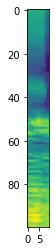

In [73]:
plt.imshow(np.load('../../data/move/180326_003_61_win2_move.npy')[0].T)

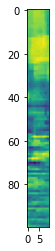

In [74]:
plt.imshow(np.load('../../data/sleep/180326_003_61_win112_sleep.npy')[0].T)
                   
             

In [ ]:
plt.imshow(ztotSpec.T[:,:1003])

In [ ]:
specs = []
for ch in range(1,62):
    ztotSpec = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['ztotSpec'][0][0]
    specs.append(ztotSpec)
ztotSpecs = np.stack(specs)

In [ ]:
ztotSpecs.shape

In [ ]:
times = ti[0][:]//1000

In [ ]:
m_start_idx = []
for start in m_start[0]:
    idx = (np.abs(times-start)).argmin()
    m_start_idx.append(idx)
    
m_stop_idx = []
for stop in m_stop[0]:
    idx = (np.abs(times-stop)).argmin()
    m_stop_idx.append(idx)
    
    
badtime_idx = []

for badtime in badtimes[0]:
    idx = (np.abs(times-badtime)).argmin()
    badtime_idx.append(idx)
    
for idx in badtime_idx:
    ztotSpecs[:,idx,:] = np.nan

    

Impute NaN on columns with badtimes, that way they are discarded. 

In [ ]:
window=10
asleeps = torch.split(asleep,split_size_or_sections=window,dim=1)

In [ ]:
prior_mvmt_idx = 0
window=10

for start_idx, stop_idx in zip(m_start_idx,m_stop_idx):
    
    asleep = torch.from_numpy(btrm_ztotSpecs[:,int(round(prior_mvmt_idx)):int(round(start_idx)),:])
    moving = torch.from_numpy(btrm_ztotSpecs[:,int(round(start_idx)):int(round(stop_idx)),:])
    prior_mvmt_idx = stop_idx
    
    print(asleep.sum(),moving.sum())
    asleeps = torch.split(asleep,split_size_or_sections=window,dim=1)
    movings = torch.split(moving,split_size_or_sections=window,dim=1)
    # Now of these two arrays, split and save, assuming it does not include a badtime index

                        # loop over these windows and save 
    for i, arr in enumerate(asleeps):
        if not torch.isnan(arr.sum()) and arr.shape[1] == window:
            np.save('../../data/sleep/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_sleep.npy',arr.numpy().T) 
    for i, arr in enumerate(movings):
        if not torch.isnan(arr.sum()) and arr.shape[1] == window:
            np.save('../../data/move/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_move.npy',arr.numpy().T) 

    
    

In [ ]:
arr.shape

In [ ]:
stop_idx

In [ ]:
#root = '/vol/sas2b/Goose_Multiscale_M1_Wireless'
#for night in os.listdir(root):
#    os.listdir(root + '/' + night)
#    break
night = '180327'
rec = '003'

os.listdir('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+rec)

#+#'/rec'+rec+'.NightEvents.mat' 

EventFile = '/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+'rec'+rec+'.NightEvents.mat'

In [ ]:
EventFile

In [ ]:
movement_df = pd.DataFrame()

nights = ['1803'+str(i) for i in range(25,31)]
recs = ['00'+str(i) for i in range(1,10)]
for night in nights:
    for rec in recs:
        print(night, rec)
        EventFile = '/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+rec+'/rec'+rec+'.NightEvents.mat'

        if os.path.exists(EventFile):

            NightEvents = loadmat(EventFile)
           # print("found night events file for ", night, ' ', rec )
           # video_start = NightEvents['NightEvents'][0][0][3][0][0][0][0][0]
           # video_stop = NightEvents['NightEvents'][0][0][3][0][0][1][0][0]
           # video_length = video_stop - video_start
           # print(night,rec,video_start,video_stop)
            try:
                starts = NightEvents['NightEvents'][0][0][1][0][0][0][0]
                stops = NightEvents['NightEvents'][0][0][1][0][0][1][0]

                #print(starts.shape)
                #if starts.shape[0] >= 1:
                print(starts.shape,stops.shape)
               # print('start = ', starts)
               # print('end = ', stops)
            except:
                try:
                    starts = NightEvents['NightEvents'][0][0][4][0][0][0][0]
                    stops = NightEvents['NightEvents'][0][0][4][0][0][1][0]
                   # print('start = ', starts)
                   # print('end = ', stops)
                    #print(starts.shape)
                   # if starts.shape[0] >= 1:
                    print(starts.shape,stops.shape)
                except:
                    #print("No mvmt found for ", night, ' ', rec)
                    pass
          #  break
       # break

        else: # Exception as e:
            #print(e)
            #print("No event file found for ", night, ' ', rec)
            pass
            


In [ ]:
starts,stops

In [ ]:
def startstop(starts,stops):
    for start, stop in zip(starts,stops):
        

In [ ]:
print(starts.shape)

In [ ]:
starts = NightEvents['NightEvents'][0][0][1][0][0][0][0]

In [ ]:
stops = NightEvents['NightEvents'][0][0][1][0][0][1][0]

In [ ]:
video_start = NightEvents['NightEvents'][0][0][3][0][0][0][0][0]
video_stop = NightEvents['NightEvents'][0][0][3][0][0][1][0][0]

In [ ]:
NightEvents['NightEvents'][0][0][0][0][0][0][0].keys

In [ ]:
movements = NightEvents['NightEvents'][0][0][4]

In [ ]:
print(movements)

In [ ]:

                mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
                mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]
                has_movements = True #transitions 

In [ ]:
def save_night_events():
    """
    Loop through all night events files, 
    """

# .mat file ordering

We can load three spectrograms for each channel, of which there are 62 channels. These three spectrograms are the entire spectrogram, no movement, movement. We only want the entire spec, which we have now, and now we want to coincide those with the movement times. 

# Main Loop

EDIT: This works assuming we have access to all the spectrograms of all the movments + all the night event files of those recordings, which is not the case. Instead, please see below where I have essentially the same loop, but only for recordings we finished labelling. 

TODO:

Compute z score across, use as indicator on whether or not to save. '

Or alternatively, look at pre-computed bad times, but I'm not seeing this yet?

In [ ]:
nights = ['1803'+str(i) for i in range(26,32)]
recs = ['00'+str(i) for i in range(1,10)]
WINDOW_LENGTH = 10
thresh = 5 # start here .. 
for night in nights: # loop over nights (180327)
    for rec in recs: #loop over recordings (003)
        try: 
            # load spectrogram + night movements of that night recording
            allspec = loadmat('../Spectrogram_mat_data/N10W1dn1_'+ night + '_rec'+rec+'.mat')
            night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+rec+'/rec'+rec+'.NightEvents.mat')
            video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
            video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
            video_length = video_stop - video_start
            try:
                mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
                mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]
                has_movements = True #transitions 
            except:
                has_movements = False
                
            for ch in range(1): # iterate over channels (just one for now)
                spec = allspec['Spec_per_Ch'][0][0][ch][0][0][0]  
                prior_mvmt = 0
                if has_movements:
                    for start, end in zip(mvmt_starts,mvmt_ends): # loop over movements
                        mvmt_start = (spec.shape[0] / video_length) * start
                        mvmt_end = (spec.shape[0] / video_length) * end #
                        window = int(round(spec.shape[0] / video_length)) *WINDOW_LENGTH
                        asleep = torch.from_numpy(spec[int(round(prior_mvmt)):int(round(mvmt_start)),:])
                        moving = torch.from_numpy(spec[int(round(mvmt_start)):int(round(mvmt_end)),:])
                        #print(' window size = ', window)
                        # after indexing split into windows
                        asleeps = torch.split(asleep,split_size_or_sections=window,dim=0)
                        movings = torch.split(moving,split_size_or_sections=window,dim=0)
                        prior_mvmt  = mvmt_end # for the next loop

                        # loop over these windows and save 
                        for i, sleep_arr in enumerate(asleeps):
                            if not torch.isnan(sleep_arr.sum()):
                                totz = zscore(abs(sleep_arr.sum(axis=1))) #flip abs before sum
                                if not np.any(abs(totz) > thresh):
                                    if sleep_arr.shape[0] == window:
                                        np.save('data/sleep/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_sleep.npy',sleep_arr.numpy().T) 
                                else:
                                    print(night, rec, i, "has badtimes.")
                        for i, sleep_arr in enumerate(movings):
                            if not torch.isnan(sleep_arr.sum()):
                                totz = zscore(abs(sleep_arr.sum(axis=1)))
                                if not np.any(abs(totz) > thresh):
                                #  print(sleep_arr.shape)
                                    if sleep_arr.shape[0] == window:
                                        np.save('data/move/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_move.npy',sleep_arr.numpy().T)
                                else:
                                    print(night, rec, i, "has badtimes.")
                else:
                    prior_rec = '00' + str(int(rec) - 1)
                    print("Using prior rec..")
                    night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+prior_rec+'/rec'+prior_rec+'.NightEvents.mat')
                    video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
                    video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
                    video_length = video_stop - video_start

                    mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
                    mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]
                    if mvmt_ends[-1] < video_stop:
                        print("Saving new events.")
                        asleeps = torch.split(asleep,split_size_or_sections=window,dim=0)
                        for i, sleep_arr in enumerate(asleeps):
                            if not torch.isnan(sleep_arr.sum()):
                                totz = zscore(abs(sleep_arr.sum(axis=1)))
                                if not np.any(abs(totz) > thresh):
                                #  print(sleep_arr.shape)
                                    if sleep_arr.shape[0] == window:
                                        np.save('data/sleep/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_sleep.npy',sleep_arr.numpy().T)
                                else:
                                    print(night, rec, i, "has badtimes.")
                    else:
                        movings = torch.split(moving,split_size_or_sections=window,dim=0)
                        for i, sleep_arr in enumerate(movings):
                            if not torch.isnan(sleep_arr.sum()): # print where this happens
                                totz = zscore(abs(sleep_arr.sum(axis=1)))
                                if not np.any(abs(totz) > thresh):
                                
                                    #  print(sleep_arr.shape)
                                    if sleep_arr.shape[0] == window:
                                        np.save('data/move/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_move.npy',sleep_arr.numpy().T)
                                else:
                                    print(night, rec, i, "has badtimes.")
            # From here I suspect it would be easy to load in 
        except Exception as e:
            print(e)
            print("Couldn't do ", night, " ", rec)
            # This means I look at this night separately, and from it I can infer what state
            # the monkey is in based on how it was as the end of the previous recording
            pass

Now let's see if this makes sense when reading in a random file...

In [ ]:
for move_spec in os.listdir('data/move/')[:25]:
    plt.figure()
    plt.title(move_spec)
    plt.imshow(np.load('data/move/'+move_spec))
    #break

In [ ]:
for sleep_spec in os.listdir('data/sleep/')[:25]:
    plt.figure()
    plt.title(sleep_spec)
    plt.imshow(np.load('data/sleep/'+sleep_spec))
    #break

In [ ]:
test_sleep_spec = np.load('data/sleep/180326_003_0_win103_sleep.npy')

In [ ]:
plt.imshow(test_sleep_spec)

### Fixing the mistake

So there are two possible failure cases 

1) No night events file created yet, which just means there's nothing to match to a label just yet.

2) There is a night events file, but there is no movement files. If that's the case, then it means the monkey is in the same state they were in at the end of the prior recording. 

3) After doing 2, it's possible that the prior recording also wasn't labeled. 

In [ ]:
# start with 180327   006
night = '180328'
rec = '001'
allspec = loadmat('../Spectrogram_mat_data/N10W1dn1_'+ night + '_rec'+rec+'.mat')
night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+rec+'/rec'+rec+'.NightEvents.mat')
video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
video_length = video_stop - video_start

#mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
#mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]
# So there are no night events. 

# In this case, head to the prior recording, load in those movements



In [ ]:
allspec

In [ ]:
prior_rec = '00' + str(int(rec) - 1)

night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+prior_rec+'/rec'+prior_rec+'.NightEvents.mat')
video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
video_length = video_stop - video_start

mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]


In [ ]:
plt.imshow(np.load('data/sleeping/180327_009_0_win7_sleep.npy'))

In [ ]:
video_stop

In [ ]:
if mvmt_ends[-1] < video_stop:
    print("Monkey was asleep as the end of ", prior_rec, ' so label all of ', rec, ' as asleep')

Use just available data, 

In [ ]:
for file in os.listdir('../Spectrogram_mat_data/'):
    night = file.split('_')[1]
    rec = file.split('.')[0][-3:]
    allspec = loadmat('../Spectrogram_mat_data/N10W1dn1_'+ night + '_rec'+rec+'.mat')
    night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+rec+'/rec'+rec+'.NightEvents.mat')
    video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
    video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
    video_length = video_stop - video_start

    mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
    mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]


    for ch in range(1): # iterate over channels (just one for now)
        spec = allspec['Spec_per_Ch'][0][0][ch][0][0][0]  
        prior_mvmt = 0
        for start, end in zip(mvmt_starts,mvmt_ends): # loop over movements
            mvmt_start = (spec.shape[0] / video_length) * start
            mvmt_end = (spec.shape[0] / video_length) * end
            window = int(round(spec.shape[0] / video_length)) *WINDOW_LENGTH

            asleep = torch.from_numpy(spec[int(round(prior_mvmt)):int(round(mvmt_start)),:])
            moving = torch.from_numpy(spec[int(round(mvmt_start)):int(round(mvmt_end)),:])

            # after indexing split into windows
            asleeps = torch.split(asleep,split_size_or_sections=window,dim=0)

            movings = torch.split(moving,split_size_or_sections=window,dim=0)
            prior_mvmt  = mvmt_end # for the next loop

            # loop over these windows and I guess save? 
            for sleep_arr in asleeps:
              #  print(sleep_arr.shape)
                if sleep_arr.shape[0] == WINDOW_LENGTH:
                    np.save('data/sleeping/' + night + '_' + rec + '_' + str(ch) + '_sleep.npy',sleep_arr.numpy().T)
                    # save as a npy file?
            for sleep_arr in movings:
               # print(sleep_arr.shape)
                if sleep_arr.shape[0] == WINDOW_LENGTH:

                    # save as a npy file? 
                    np.save('data/moving/' + night + '_' + rec + '_' + str(ch) + '_move.npy',sleep_arr.numpy().T)

    # From here I suspect it would be easy to load in 



Rec 8 on 326, is there no movement or all movemnt? What should we say in this case? 

In [ ]:
 spec = allspec['Spec_per_Ch'][0][0][ch][0][0][0]

In [ ]:
plt.imshow(spec.T[:,0:100])

In [ ]:
plt.imshow(np.load('data/moving/180327_001_0_move.npy'))

In [ ]:
plt.imshow(np.load('data/sleeping/180327_001_0_win117_sleep.npy'))

Possibilities, if in recording 1 no movement mentioned, then we assume the monkey was moving the whole time. 

In [ ]:
len(os.listdir('data/moving/'))

In [ ]:
len(os.listdir('data/sleeping/'))